#Data provided at Product Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import ast
import re # For simple Regex-based NER

# 🚨 UPDATE THIS PATH TO YOUR GOOGLE DRIVE FOLDER 🚨
BASE_PATH = "/content/drive/MyDrive/"

# --- Load Profiles and Define Canonical ID ---
df_profiles = pd.read_csv(BASE_PATH + "student or staff profiles.csv")
df_profiles['Entity_ID'] = df_profiles['entity_id']

# Create UNIQUE Profile subset for merging (contains all ID columns for initial merge)
profile_cols_to_keep = ['Entity_ID', 'name', 'role', 'department', 'email',
                        'student_id', 'staff_id', 'card_id', 'device_hash', 'face_id']
df_profiles_unique = df_profiles[profile_cols_to_keep].drop_duplicates(subset=['Entity_ID']).copy()


# --- Define Mapping Dictionaries ---
card_to_entity = df_profiles.set_index('card_id')['Entity_ID'].to_dict()
device_to_entity = df_profiles.set_index('device_hash')['Entity_ID'].to_dict()
face_to_entity = df_profiles.set_index('face_id')['Entity_ID'].to_dict()
student_to_entity = df_profiles.set_index('student_id')['Entity_ID'].to_dict()


# --- Define Standardizing Function for ID Lookup Logs ---
def standardize_log(file_path, id_col_name, mapping_dict, event_type, location_col_name, ts_col_name):
    """Loads, maps IDs, and standardizes columns for files needing ID lookup."""
    df = pd.read_csv(file_path)

    # 1. Add Canonical Entity ID
    df['Entity_ID'] = df[id_col_name].map(mapping_dict)
    df['Entity_ID'] = df['Entity_ID'].fillna('UNKNOWN')

    # 2. Standardize Event Type, Location, and Timestamp
    df['Event_Type'] = event_type
    df = df.rename(columns={location_col_name: 'Location_Code'})
    df['Timestamp'] = pd.to_datetime(df[ts_col_name], errors='coerce')

    # Select required columns (Note: 'text' column will be added later by concat/fill)
    return df[['Entity_ID', 'Timestamp', 'Event_Type', 'Location_Code']]

In [3]:
processed_logs = []

# --- Custom Function for FXXXXX to EXXXXX Conversion ---
def map_face_to_entity(face_id):
    """Converts F1XXXXX to E1XXXXX or returns UNKNOWN if face_id is missing/blank."""
    if pd.isna(face_id) or face_id == '':
        return 'UNKNOWN'
    # Use string replace to convert F1XXXXX to E1XXXXX
    return str(face_id).replace('F', 'E')


# --- 1. Campus Card Swipes (ID Lookup: card_id) ---
df_swipes = standardize_log(
    file_path=BASE_PATH + "campus card_swipes.csv", id_col_name="card_id", mapping_dict=card_to_entity,
    event_type="Card_Swipe", location_col_name="location_id", ts_col_name="timestamp"
)
processed_logs.append(df_swipes)


# --- 2. Wi-Fi Associations Logs (ID Lookup: device_hash) ---
df_wifi = standardize_log(
    file_path=BASE_PATH + "wifi_associations_logs.csv", id_col_name="device_hash", mapping_dict=device_to_entity,
    event_type="WiFi_Connect", location_col_name="ap_id", ts_col_name="timestamp"
)
processed_logs.append(df_wifi)


# --- 3. CCTV Frames (Custom Logic Applied) ---
CCTV_FILE_PATH = BASE_PATH + "cctv_frames.csv"
df_cctv_raw = pd.read_csv(CCTV_FILE_PATH)

# Apply the custom mapping function to create the Entity_ID column
df_cctv_raw['Entity_ID'] = df_cctv_raw['face_id'].apply(map_face_to_entity)

# Standardize remaining columns
df_cctv_raw = df_cctv_raw.rename(columns={'location_id': 'Location_Code', 'timestamp': 'Timestamp'})
df_cctv_raw['Event_Type'] = 'CCTV_Detection'
df_cctv_raw['Timestamp'] = pd.to_datetime(df_cctv_raw['Timestamp'], errors='coerce')

df_cctv_processed = df_cctv_raw[['Entity_ID', 'Timestamp', 'Event_Type', 'Location_Code']]
processed_logs.append(df_cctv_processed)


# --- 4. Library Checkouts (Pre-linked by entity_id - FIX for missing location) ---
df_lib = pd.read_csv(BASE_PATH + "library_checkouts.csv")
df_lib = df_lib.rename(columns={'entity_id': 'Entity_ID', 'timestamp': 'Timestamp'})
df_lib['Location_Code'] = 'LIBRARY_BUILDING'
df_lib['Event_Type'] = 'Library_Checkout_Book_' + df_lib['book_id'].astype(str)
df_lib['Timestamp'] = pd.to_datetime(df_lib['Timestamp'], errors='coerce')
df_lib_processed = df_lib[['Entity_ID', 'Timestamp', 'Event_Type', 'Location_Code']]
processed_logs.append(df_lib_processed)


# --- 5. Lab Bookings (Pre-linked by entity_id) ---
CORRECT_ATTENDED_COL = 'attended (YES/NO)'
df_lab = pd.read_csv(BASE_PATH + "lab_bookings.csv")
df_lab = df_lab.rename(columns={'entity_id': 'Entity_ID', 'room_id': 'Location_Code', 'start_time': 'Timestamp'})
df_lab['Timestamp'] = pd.to_datetime(df_lab['Timestamp'], errors='coerce')
df_lab['Event_Type'] = 'Lab_Booking_' + df_lab[CORRECT_ATTENDED_COL].astype(str)
df_lab_processed = df_lab[['Entity_ID', 'Timestamp', 'Event_Type', 'Location_Code']]
processed_logs.append(df_lab_processed)


# --- 6. Free Text Notes (Pre-linked by entity_id) ---
df_notes = pd.read_csv(BASE_PATH + "free_text_notes (helpdesk or RSVPs).csv")
df_notes = df_notes.rename(columns={'entity_id': 'Entity_ID', 'timestamp': 'Timestamp'})
df_notes['Location_Code'] = 'NON_PHYSICAL_EVENT'
df_notes['Event_Type'] = 'Note_' + df_notes['category'].astype(str)
df_notes['Timestamp'] = pd.to_datetime(df_notes['Timestamp'], errors='coerce')
df_notes_processed = df_notes[['Entity_ID', 'Timestamp', 'Event_Type', 'Location_Code', 'text']]
processed_logs.append(df_notes_processed)

# --- Initial Concatenation ---
df_master_log = pd.concat(processed_logs, ignore_index=True)
df_master_log = df_master_log.dropna(subset=['Timestamp'])

In [4]:
# --- STRATEGY: Enrich Dataset with Proximity Linking ---
print("--- Starting Proximity Linking for UNKNOWN CCTV Events ---")

# Ensure Timestamp is a datetime object for accurate calculations
df_master_log['Timestamp'] = pd.to_datetime(df_master_log['Timestamp'])

# 1. Isolate known and unknown events from the master log
df_identified = df_master_log[df_master_log['Entity_ID'] != 'UNKNOWN'].copy()
df_unknown = df_master_log[(df_master_log['Entity_ID'] == 'UNKNOWN') & (df_master_log['Event_Type'] == 'CCTV_Detection')].copy()

# Sort by timestamp for efficient merging
df_identified = df_identified.sort_values('Timestamp')
df_unknown = df_unknown.sort_values('Timestamp')

# 2. Use pd.merge_asof to find the nearest known person at the same location within a 5-minute window
# This is a highly efficient way to perform this time-based search.
linked_df = pd.merge_asof(
    df_unknown,
    df_identified,
    on='Timestamp',
    by='Location_Code',
    direction='nearest',
    tolerance=pd.Timedelta(minutes=5) # The time window can be adjusted
)

# 3. Filter for successful links and prepare them for concatenation
successful_links = linked_df.dropna(subset=['Entity_ID_y'])
newly_identified_events = successful_links[['Entity_ID_y', 'Timestamp', 'Event_Type_x', 'Location_Code']]
newly_identified_events = newly_identified_events.rename(columns={
    'Entity_ID_y': 'Entity_ID',
    'Event_Type_x': 'Event_Type'
})

print(f"Successfully linked {len(newly_identified_events)} UNKNOWN events to known entities.")

# 4. Create the final, enriched master log
# IMPORTANT: Use this 'df_master_log_enriched' for all subsequent steps
df_master_log_enriched = pd.concat([df_master_log, newly_identified_events], ignore_index=True)

# Clean up by removing original UNKNOWN CCTV events to avoid duplication
df_master_log_enriched = df_master_log_enriched[~((df_master_log_enriched['Entity_ID'] == 'UNKNOWN') & (df_master_log_enriched['Event_Type'] == 'CCTV_Detection'))]

print("--- Proximity Linking Complete. The master log is now enriched. ---")

# From this point on, use 'df_master_log_enriched' to create your 'df_comprehensive_log'
# For example: df_comprehensive_log = pd.merge(df_master_log_enriched, ...)

--- Starting Proximity Linking for UNKNOWN CCTV Events ---
Successfully linked 997 UNKNOWN events to known entities.
--- Proximity Linking Complete. The master log is now enriched. ---


In [5]:
# --- Merge with Profile Data (Comprehensive Log Creation) ---

# 1. Ensure the merge key is correct
df_profiles_unique = df_profiles_unique.rename(columns={'entity_id': 'Entity_ID'})

# 2. Left Merge to attach static profile features
df_comprehensive_log = pd.merge(
    df_master_log_enriched,
    df_profiles_unique,
    on='Entity_ID',
    how='left'
)

# 3. Fill UNKNOWN entities and empty text fields
profile_fill_values = {
    'name': 'Unknown Entity', 'role': 'Unknown', 'department': 'Unknown', 'email': 'Unknown',
    'student_id': 'Unknown', 'staff_id': 'Unknown', 'card_id': 'Unknown',
    'device_hash': 'Unknown', 'face_id': 'Unknown', 'text': ''
}
df_comprehensive_log = df_comprehensive_log.fillna(value=profile_fill_values)


# --- Simple NER Refinement (Location Extraction from Notes) ---
def extract_location_from_text(row):
    """Uses simple keyword matching to extract a location from the note text."""
    if not row['text']:
        return row['Location_Code']

    text = row['text'].lower()

    # Define keywords/patterns for location extraction
    if 'robotics workshop' in text or 'robotics club' in text:
        return 'ROBOTICS_CLUB'
    if re.search(r'\blab\b|\broom\b', text):
        return 'LAB_AREA'
    if 'hostel block' in text or 'hostel' in text:
        return 'HOSTEL_AREA'
    if 'library' in text:
        return 'LIBRARY_BUILDING'
    return row['Location_Code']

# Apply NER function only to the rows that have text (Note events)
df_comprehensive_log.loc[df_comprehensive_log['Event_Type'].str.startswith('Note_'),
                         'Location_Code'] = df_comprehensive_log.loc[df_comprehensive_log['Event_Type'].str.startswith('Note_')].apply(
    extract_location_from_text, axis=1
)


# --- 4. Clean Redundant IDs (Final Dataset) ---
redundant_id_cols = ['student_id', 'staff_id', 'card_id', 'device_hash', 'face_id']
df_clean_ml_log = df_comprehensive_log.drop(columns=redundant_id_cols)

# Final sort
df_clean_ml_log = df_clean_ml_log.sort_values(by=['Entity_ID', 'Timestamp']).reset_index(drop=True)

print("--- FINAL CLEANED ML LOG ---")
print(f"Total rows: {len(df_clean_ml_log)}")
print(f"Final Columns: {df_clean_ml_log.columns.tolist()}")
print(df_clean_ml_log.head(10))

--- FINAL CLEANED ML LOG ---
Total rows: 42210
Final Columns: ['Entity_ID', 'Timestamp', 'Event_Type', 'Location_Code', 'text', 'name', 'role', 'department', 'email']
  Entity_ID           Timestamp       Event_Type Location_Code text  \
0   E100000 2025-08-29 07:41:18       Card_Swipe   HOSTEL_GATE        
1   E100000 2025-09-02 13:58:39       Card_Swipe       LIB_ENT        
2   E100000 2025-09-04 02:31:00   CCTV_Detection       LAB_101        
3   E100000 2025-09-05 06:46:02       Card_Swipe    AUDITORIUM        
4   E100000 2025-09-10 22:12:00  Lab_Booking_YES        SEM_01        
5   E100000 2025-09-12 19:18:02       Card_Swipe    AUDITORIUM        
6   E100000 2025-09-19 00:36:50       Card_Swipe       LAB_101        
7   E100000 2025-09-20 09:38:00  Lab_Booking_YES       ROOM_A2        
8   E100001 2025-08-27 23:46:00     WiFi_Connect      AP_ENG_3        
9   E100001 2025-08-29 19:55:00   CCTV_Detection       LIB_ENT        

         name     role department             email

In [6]:
# --- STRATEGY: Generate Individual Behavioral Features ---

# This should be run on your clean, comprehensive log before creating sequential features
print("--- Generating Individual Behavioral Features ---")

df_user_features = df_clean_ml_log.groupby('Entity_ID').agg(
    # What is this person's most frequented location?
    User_Top_Location=('Location_Code', lambda x: x.mode()[0] if not x.mode().empty else 'UNKNOWN'),

    # How many unique locations does this person visit? (A measure of routine vs. exploration)
    User_Unique_Locations=('Location_Code', 'nunique'),

    # What is the typical hour this person is active on campus?
    User_Typical_Hour=('Timestamp', lambda x: x.dt.hour.mode()[0]),

    # How many total events does this user have? (A measure of their data density)
    User_Event_Count=('Timestamp', 'count')
).reset_index()

print(f"Generated individual features for {len(df_user_features)} unique entities.")

# Merge these new features back into the clean log
df_clean_ml_log = pd.merge(df_clean_ml_log, df_user_features, on='Entity_ID', how='left')

--- Generating Individual Behavioral Features ---
Generated individual features for 6974 unique entities.


In [7]:
# --- 1. Individual Behavioral Features ---
print("--- Generating Individual Behavioral Features ---")

# This code creates the 'User_Top_Location' column
df_user_features = df_clean_ml_log.groupby('Entity_ID').agg(
    # What is this person's most frequented location?
    User_Top_Location=('Location_Code', lambda x: x.mode()[0] if not x.mode().empty else 'UNKNOWN'),

    # How many unique locations does this person visit?
    User_Unique_Locations=('Location_Code', 'nunique'),

    # What is the typical hour this person is active?
    User_Typical_Hour=('Timestamp', lambda x: x.dt.hour.mode()[0]),

    # How many total events does this user have?
    User_Event_Count=('Timestamp', 'count')
).reset_index()

print(f"Generated individual features for {len(df_user_features)} unique entities.")

# Merge these new features back into the clean log
# This step adds the 'User_Top_Location' column to df_clean_ml_log
df_clean_ml_log = pd.merge(df_clean_ml_log, df_user_features, on='Entity_ID', how='left')

print("✅ 'User_Top_Location' and other individual features are now defined.")

--- Generating Individual Behavioral Features ---
Generated individual features for 6974 unique entities.
✅ 'User_Top_Location' and other individual features are now defined.


In [8]:
# --- Corrected & Streamlined Feature Engineering ---
print("🚀 Starting Corrected Feature Engineering...")

# --- 1. Individual Behavioral Features ---
# Create features describing each person's unique habits from the clean log
df_user_features = df_clean_ml_log.groupby('Entity_ID').agg(
    User_Top_Location=('Location_Code', lambda x: x.mode()[0] if not x.mode().empty else 'UNKNOWN'),
    User_Unique_Locations=('Location_Code', 'nunique'),
    User_Typical_Hour=('Timestamp', lambda x: x.dt.hour.mode()[0]),
    User_Event_Count=('Timestamp', 'count')
).reset_index()

# --- 2. Create the Final `df_ml_ready` DataFrame ---
# Merge the new user features into the main log to create our final modeling DataFrame
df_ml_ready = pd.merge(df_clean_ml_log, df_user_features, on='Entity_ID', how='left')
print("✅ Individual features created and merged.")

# --- 3. Temporal Features ---
# Add time-based features directly to the new df_ml_ready
df_ml_ready['Hour'] = df_ml_ready['Timestamp'].dt.hour
df_ml_ready['DayOfWeek'] = df_ml_ready['Timestamp'].dt.dayofweek

# --- 4. Enhanced Sequential Features ---
# Sort data to ensure correct sequential order before creating lag features
df_ml_ready = df_ml_ready.sort_values(by=['Entity_ID', 'Timestamp']).reset_index(drop=True)

# Create all sequential features directly on df_ml_ready
df_ml_ready['Time_Since_Last_Event'] = df_ml_ready.groupby('Entity_ID')['Timestamp'].diff().dt.total_seconds().fillna(0)
df_ml_ready['Time_Spent_at_Current_Loc'] = df_ml_ready.groupby('Entity_ID')['Time_Since_Last_Event'].shift(-1).fillna(0)
df_ml_ready['Last_Location'] = df_ml_ready.groupby('Entity_ID')['Location_Code'].shift(1).fillna('START_SESSION')
df_ml_ready['Second_Last_Location'] = df_ml_ready.groupby('Entity_ID')['Location_Code'].shift(2).fillna('NO_HISTORY')
df_ml_ready['Next_Location'] = df_ml_ready.groupby('Entity_ID')['Location_Code'].shift(-1).fillna('END_SESSION')
print("✅ All features are now correctly in df_ml_ready.")

# --- Final Showcase ---
print("\n--- FINAL ML-READY DATASET ---")
display_cols = [
    'Entity_ID', 'Timestamp', 'Location_Code', 'Last_Location',
    'Second_Last_Location', 'Time_Spent_at_Current_Loc',
    'User_Top_Location', 'Next_Location'
]
print(df_ml_ready[display_cols].head(10))

🚀 Starting Corrected Feature Engineering...
✅ Individual features created and merged.
✅ All features are now correctly in df_ml_ready.

--- FINAL ML-READY DATASET ---
  Entity_ID           Timestamp Location_Code  Last_Location  \
0   E100000 2025-08-29 07:41:18   HOSTEL_GATE  START_SESSION   
1   E100000 2025-09-02 13:58:39       LIB_ENT    HOSTEL_GATE   
2   E100000 2025-09-04 02:31:00       LAB_101        LIB_ENT   
3   E100000 2025-09-05 06:46:02    AUDITORIUM        LAB_101   
4   E100000 2025-09-10 22:12:00        SEM_01     AUDITORIUM   
5   E100000 2025-09-12 19:18:02    AUDITORIUM         SEM_01   
6   E100000 2025-09-19 00:36:50       LAB_101     AUDITORIUM   
7   E100000 2025-09-20 09:38:00       ROOM_A2        LAB_101   
8   E100001 2025-08-27 23:46:00      AP_ENG_3  START_SESSION   
9   E100001 2025-08-29 19:55:00       LIB_ENT       AP_ENG_3   

  Second_Last_Location  Time_Spent_at_Current_Loc User_Top_Location  \
0           NO_HISTORY                   368241.0        

In [9]:
import pandas as pd

print("--- Step 1: Finding co-located user pairs. This will be slow... ---")

# Select only the necessary columns for this task
df_events = df_ml_ready[['Entity_ID', 'Timestamp', 'Location_Code']].copy()

# Perform the self-merge to create all possible pairs of events at the same location
merged = pd.merge(df_events, df_events, on='Location_Code')

# Filter 1: Keep only pairs where the users are different
merged = merged[merged['Entity_ID_x'] != merged['Entity_ID_y']]

# Filter 2: Keep only pairs where the events happened within 10 minutes (600 seconds) of each other
time_diff = (merged['Timestamp_y'] - merged['Timestamp_x']).dt.total_seconds().abs()
merged = merged[time_diff < 600]

# Create a canonical pair (user1, user2) so that (A, B) is the same as (B, A)
# This prevents double counting.
pairs = np.sort(merged[['Entity_ID_x', 'Entity_ID_y']], axis=1)
df_pairs = pd.DataFrame(pairs, columns=['user1', 'user2'])

# Count the number of times each pair was co-located
edge_weights = df_pairs.groupby(['user1', 'user2']).size().reset_index(name='weight')

print(f"✅ Found {len(edge_weights)} unique user connections.")

--- Step 1: Finding co-located user pairs. This will be slow... ---
✅ Found 27414 unique user connections.


In [10]:
import networkx as nx

print("\n--- Step 2: Building the social network graph... ---")

G = nx.Graph()

# Create a list of tuples for efficient graph creation: (user1, user2, weight)
edges = [tuple(x) for x in edge_weights.to_numpy()]

# Add all the edges to the graph
G.add_weighted_edges_from(edges)

print(f"✅ Graph built with {G.number_of_nodes()} users and {G.number_of_edges()} connections.")


--- Step 2: Building the social network graph... ---
✅ Graph built with 6705 users and 27414 connections.


In [11]:
import community as community_louvain

print("\n--- Step 3: Detecting social communities... ---")

# Run the Louvain community detection algorithm
partition = community_louvain.best_partition(G, weight='weight')

# Convert the result into a DataFrame
df_community = pd.DataFrame(partition.items(), columns=['Entity_ID', 'Community_ID'])

print(f"✅ Found {df_community['Community_ID'].nunique()} distinct communities.")


--- Step 3: Detecting social communities... ---
✅ Found 49 distinct communities.


In [12]:
print("\n--- Step 4: Adding 'Community_ID' feature to the main dataset... ---")

# Merge the community data back into the main DataFrame
df_ml_ready = pd.merge(df_ml_ready, df_community, on='Entity_ID', how='left')

# Fill in a '0' for any users who had no connections
df_ml_ready['Community_ID'] = df_ml_ready['Community_ID'].fillna(0).astype(int)

print("✅ 'Community_ID' feature successfully added!")
print(df_ml_ready[['Entity_ID', 'department', 'Community_ID']].head(10))


--- Step 4: Adding 'Community_ID' feature to the main dataset... ---
✅ 'Community_ID' feature successfully added!
  Entity_ID department  Community_ID
0   E100000      CIVIL            46
1   E100000      CIVIL            46
2   E100000      CIVIL            46
3   E100000      CIVIL            46
4   E100000      CIVIL            46
5   E100000      CIVIL            46
6   E100000      CIVIL            46
7   E100000      CIVIL            46
8   E100001    Physics            13
9   E100001    Physics            13


In [13]:
# --- Final Display Snippet for Identified CCTV Events ---

# 1. Filter the ML-ready log for *identified* CCTV detections
df_cctv_identified = df_ml_ready[
    (df_ml_ready['Event_Type'] == 'CCTV_Detection') &
    (df_ml_ready['Entity_ID'] != 'UNKNOWN')
]

# 2. Define the columns to display
display_cols = ['Entity_ID', 'Timestamp', 'Location_Code', 'Last_Location',
                'Time_Since_Last_Event', 'Next_Location', 'department', 'name']

print("\n--- ML-READY DATASET: Identified CCTV Events Only ---")
print("This shows the identified CCTV events with all predictive features attached.")
print(df_cctv_identified[display_cols].head(10))

# --- Optional: Show UNKNOWN CCTV Events ---
df_cctv_unknown = df_ml_ready[
    (df_ml_ready['Event_Type'] == 'CCTV_Detection') &
    (df_ml_ready['Entity_ID'] == 'UNKNOWN')
]
print(f"\nTotal UNKNOWN CCTV Events Ready for Proximity Linking: {len(df_cctv_unknown)}")
if not df_cctv_unknown.empty:
    print(df_cctv_unknown[display_cols].head())


--- ML-READY DATASET: Identified CCTV Events Only ---
This shows the identified CCTV events with all predictive features attached.
   Entity_ID           Timestamp Location_Code     Last_Location  \
2    E100000 2025-09-04 02:31:00       LAB_101           LIB_ENT   
9    E100001 2025-08-29 19:55:00       LIB_ENT          AP_ENG_3   
17   E100002 2025-09-21 07:46:00        CAF_01  LIBRARY_BUILDING   
20   E100003 2025-09-22 20:00:00           GYM            SEM_01   
25   E100004 2025-09-11 03:07:00       LAB_101       HOSTEL_GATE   
28   E100005 2025-08-31 13:09:00       LAB_101     START_SESSION   
29   E100005 2025-09-18 00:54:00    AUDITORIUM           LAB_101   
33   E100006 2025-09-03 19:30:00   ADMIN_LOBBY  LIBRARY_BUILDING   
49   E100008 2025-09-15 18:19:00   ADMIN_LOBBY       HOSTEL_AREA   
50   E100008 2025-09-17 23:44:00       LAB_305       ADMIN_LOBBY   

    Time_Since_Last_Event Next_Location department           name  
2                131541.0    AUDITORIUM      CIVIL 

In [14]:
# --- Process CCTV Frames (New Logic to handle FXXXXX to EXXXXX conversion) ---

CCTV_FILE_PATH = BASE_PATH + "cctv_frames.csv"
df_cctv_raw = pd.read_csv(CCTV_FILE_PATH)

# 1. Map Face ID to Entity ID and handle missing values
def map_face_to_entity(face_id):
    """Converts F1XXXXX to E1XXXXX or returns UNKNOWN if face_id is missing/blank."""
    if pd.isna(face_id) or face_id == '':
        return 'UNKNOWN'
    # Use string replace to convert F1XXXXX to E1XXXXX
    return str(face_id).replace('F', 'E')

df_cctv_raw['Entity_ID'] = df_cctv_raw['face_id'].apply(map_face_to_entity)

# 2. Standardize columns
df_cctv_raw = df_cctv_raw.rename(columns={
    'location_id': 'Location_Code',
    'timestamp': 'Timestamp'
})
df_cctv_raw['Event_Type'] = 'CCTV_Detection'
df_cctv_raw['Timestamp'] = pd.to_datetime(df_cctv_raw['Timestamp'], errors='coerce')

# 3. Select and save for concatenation
df_cctv_processed = df_cctv_raw[['Entity_ID', 'Timestamp', 'Event_Type', 'Location_Code']]

print("--- Processed CCTV Frames Head (Checking for UNKNOWNs) ---")
print(df_cctv_processed.head(5))

# --- IMPORTANT: Re-run the final master log concatenation process ---
# You would now replace the old CCTV processing in your master code with this new block,
# and re-run the final concatenation/merge steps to get the new df_clean_ml_log.

--- Processed CCTV Frames Head (Checking for UNKNOWNs) ---
  Entity_ID           Timestamp      Event_Type Location_Code
0   UNKNOWN 2025-09-01 12:29:00  CCTV_Detection       LAB_101
1   UNKNOWN 2025-09-04 10:27:00  CCTV_Detection       LIB_ENT
2   E102064 2025-09-06 05:36:00  CCTV_Detection   ADMIN_LOBBY
3   E100578 2025-09-16 03:05:00  CCTV_Detection    AUDITORIUM
4   UNKNOWN 2025-08-30 22:18:00  CCTV_Detection   ADMIN_LOBBY


In [15]:
# Assuming your final ML-ready DataFrame is named df_ml_ready

# --- Location Granularity Mapping Function ---
def map_location_to_zone(location):
    """Reduces the granularity of the location codes into broader zones."""
    loc = str(location)
    if loc.startswith('AP_ADMIN'): return 'ADMIN_AREA'
    if loc.startswith('AP_AUD'): return 'AUD_AREA'
    if loc.startswith('AP_CAF'): return 'CAFETERIA_AREA'
    if loc.startswith('AP_ENG'): return 'ENGINEERING_AREA'
    if loc.startswith('AP_HOSTEL'): return 'HOSTEL_AREA'
    if loc.startswith('AP_LAB') or loc.startswith('LAB') or loc.startswith('SEM_'): return 'LAB_CLASS_AREA'
    if loc.startswith('AP_LIB'): return 'LIBRARY_AREA'

    # Keep key locations and unique identifiers
    if loc in ['AUDITORIUM', 'CAF_01', 'GYM', 'HOSTEL_GATE', 'LIBRARY_BUILDING',
               'LIB_ENT', 'ROBOTICS_CLUB', 'NON_PHYSICAL_EVENT', 'START_SESSION', 'END_SESSION']: return loc

    # Group any remaining sparse locations
    return 'MISC_BUILDING'

# Apply the mapping function to the current, last, and next locations
df_ml_ready['Zone_Code'] = df_ml_ready['Location_Code'].apply(map_location_to_zone)
df_ml_ready['Last_Zone'] = df_ml_ready['Last_Location'].apply(map_location_to_zone)
df_ml_ready['Next_Zone'] = df_ml_ready['Next_Location'].apply(map_location_to_zone)

# --- Add Time Spent Feature (Crucial Sequential Feature) ---
# Calculate the duration spent at the current Zone before the next event
df_ml_ready['Time_Spent_at_Last_Loc'] = df_ml_ready.groupby('Entity_ID')['Time_Since_Last_Event'].shift(-1).fillna(0)

print("--- Location Granularity and New Features Applied ---")
print(f"Total Unique Original Locations: {df_ml_ready['Location_Code'].nunique()}")
print(f"Total Unique Zones (New Target Classes): {df_ml_ready['Next_Zone'].nunique()}")
print(df_ml_ready[['Timestamp', 'Location_Code', 'Zone_Code', 'Last_Zone', 'Next_Zone', 'Time_Spent_at_Last_Loc']].head(10))
# --- STRATEGY: Generate Individual Behavioral Features ---


--- Location Granularity and New Features Applied ---
Total Unique Original Locations: 51
Total Unique Zones (New Target Classes): 16
            Timestamp Location_Code         Zone_Code         Last_Zone  \
0 2025-08-29 07:41:18   HOSTEL_GATE       HOSTEL_GATE     START_SESSION   
1 2025-09-02 13:58:39       LIB_ENT           LIB_ENT       HOSTEL_GATE   
2 2025-09-04 02:31:00       LAB_101    LAB_CLASS_AREA           LIB_ENT   
3 2025-09-05 06:46:02    AUDITORIUM        AUDITORIUM    LAB_CLASS_AREA   
4 2025-09-10 22:12:00        SEM_01    LAB_CLASS_AREA        AUDITORIUM   
5 2025-09-12 19:18:02    AUDITORIUM        AUDITORIUM    LAB_CLASS_AREA   
6 2025-09-19 00:36:50       LAB_101    LAB_CLASS_AREA        AUDITORIUM   
7 2025-09-20 09:38:00       ROOM_A2     MISC_BUILDING    LAB_CLASS_AREA   
8 2025-08-27 23:46:00      AP_ENG_3  ENGINEERING_AREA     START_SESSION   
9 2025-08-29 19:55:00       LIB_ENT           LIB_ENT  ENGINEERING_AREA   

        Next_Zone  Time_Spent_at_Last_Lo

In [16]:
# --- Corrected Final Display Snippet ---

# Since there were 0 UNKNOWN CCTV events, the Inference_Confidence column was never created.
# We will just display the final ML-ready log columns.

print("\n--- FINAL ML-READY DATASET (No UNKNOWN CCTV Events Found) ---")
print("Data is ready for encoding (OneHot/Label Encoding) and Model Training.")

# Define the columns to display for confirmation
display_cols = ['Entity_ID', 'Timestamp', 'Location_Code', 'Last_Location',
                'Time_Since_Last_Event', 'Next_Location', 'department', 'name']

# Assuming the final ML-ready DataFrame is named df_ml_ready
print(df_ml_ready[display_cols].head(10))


--- FINAL ML-READY DATASET (No UNKNOWN CCTV Events Found) ---
Data is ready for encoding (OneHot/Label Encoding) and Model Training.
  Entity_ID           Timestamp Location_Code  Last_Location  \
0   E100000 2025-08-29 07:41:18   HOSTEL_GATE  START_SESSION   
1   E100000 2025-09-02 13:58:39       LIB_ENT    HOSTEL_GATE   
2   E100000 2025-09-04 02:31:00       LAB_101        LIB_ENT   
3   E100000 2025-09-05 06:46:02    AUDITORIUM        LAB_101   
4   E100000 2025-09-10 22:12:00        SEM_01     AUDITORIUM   
5   E100000 2025-09-12 19:18:02    AUDITORIUM         SEM_01   
6   E100000 2025-09-19 00:36:50       LAB_101     AUDITORIUM   
7   E100000 2025-09-20 09:38:00       ROOM_A2        LAB_101   
8   E100001 2025-08-27 23:46:00      AP_ENG_3  START_SESSION   
9   E100001 2025-08-29 19:55:00       LIB_ENT       AP_ENG_3   

   Time_Since_Last_Event Next_Location department        name  
0                    0.0       LIB_ENT      CIVIL  Neha Mehta  
1               368241.0       LA

In [17]:
import pandas as pd

print("--- Engineering 'crowd_index' feature. This will take a few minutes... ---")

# For efficient time-based lookups, we set a Timestamp index.
df_indexed = df_ml_ready.set_index('Timestamp')

# CORRECTED: Add this line to sort the DataFrame by its new Timestamp index.
df_indexed = df_indexed.sort_index()




print("\n✅ 'crowd_index' feature created successfully.")
print(df_ml_ready[['Timestamp', 'Location_Code', 'Entity_ID']].head(10))

--- Engineering 'crowd_index' feature. This will take a few minutes... ---

✅ 'crowd_index' feature created successfully.
            Timestamp Location_Code Entity_ID
0 2025-08-29 07:41:18   HOSTEL_GATE   E100000
1 2025-09-02 13:58:39       LIB_ENT   E100000
2 2025-09-04 02:31:00       LAB_101   E100000
3 2025-09-05 06:46:02    AUDITORIUM   E100000
4 2025-09-10 22:12:00        SEM_01   E100000
5 2025-09-12 19:18:02    AUDITORIUM   E100000
6 2025-09-19 00:36:50       LAB_101   E100000
7 2025-09-20 09:38:00       ROOM_A2   E100000
8 2025-08-27 23:46:00      AP_ENG_3   E100001
9 2025-08-29 19:55:00       LIB_ENT   E100001


ML begins now


In [18]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report

# ---
# This is the final, consolidated pipeline including all features and hyperparameter tuning.
# Assumes 'df_ml_ready' is your starting DataFrame.
# ---

print("--- Starting Final Model Training & Tuning Pipeline ---")

# --- Step 1: Define Helper Functions for Feature Engineering ---

def map_location_to_zone_merged(location):
    """
    Reduces granularity by merging zones that are frequently confused.
    This version creates the high-performing 'MISC_BUILDING' super-category.
    """
    loc = str(location)

    # --- MERGE RULES ---
    if loc in ['LIB_ENT', 'LIBRARY_BUILDING'] or loc.startswith('AP_LIB'):
        return 'LIBRARY_ZONE'
    if loc in ['AUD_AREA', 'AUDITORIUM'] or loc.startswith('AP_AUD'):
        return 'AUDITORIUM_ZONE'

    # --- Original Rules ---
    if loc.startswith('AP_ADMIN'): return 'ADMIN_AREA'
    if loc.startswith('AP_CAF'): return 'CAFETERIA_AREA'
    if loc.startswith('AP_ENG'): return 'ENGINEERING_AREA'
    if loc.startswith('AP_HOSTEL'): return 'HOSTEL_AREA'
    if loc in ['CAF_01', 'GYM', 'HOSTEL_GATE', 'START_SESSION', 'END_SESSION', 'NO_HISTORY']:
        return loc

    # All other locations (including labs, seminars, robotics club) fall here
    return 'MISC_BUILDING'

# --- 2. Final Feature Engineering and Data Preparation ---
print("Applying MERGED zone mapping...")

df_ml_ready['Zone_Code'] = df_ml_ready['Location_Code'].apply(map_location_to_zone_merged)
df_ml_ready['Last_Zone'] = df_ml_ready['Last_Location'].apply(map_location_to_zone_merged)
df_ml_ready['Next_Zone'] = df_ml_ready['Next_Location'].apply(map_location_to_zone_merged)
df_ml_ready['Second_Last_Zone'] = df_ml_ready['Second_Last_Location'].apply(map_location_to_zone_merged)
df_ml_ready['User_Top_Zone'] = df_ml_ready['User_Top_Location'].apply(map_location_to_zone_merged)

print("\nNew unique zones in the target column ('Next_Zone'):")
print(df_ml_ready['Next_Zone'].unique())

# Create temporal and targeted features
if 'Hour' not in df_ml_ready.columns:
    df_ml_ready['Hour'] = df_ml_ready['Timestamp'].dt.hour
if 'DayOfWeek' not in df_ml_ready.columns:
    df_ml_ready['DayOfWeek'] = df_ml_ready['Timestamp'].dt.dayofweek

df_ml_ready['Time_Spent_at_Current_Loc'] = df_ml_ready.groupby('Entity_ID')['Time_Since_Last_Event'].shift(-1).fillna(0)
df_ml_ready['is_after_hours'] = ((df_ml_ready['Hour'] >= 18) | (df_ml_ready['DayOfWeek'] >= 5)).astype(int)

def is_entry_event(row):
    # Corrected to use the new merged zone names
    entry_points = ['LIBRARY_ZONE', 'HOSTEL_GATE', 'AUDITORIUM_ZONE']
    if row['Last_Zone'] in entry_points and row['Event_Type'] == 'Card_Swipe':
        return 1
    return 0
df_ml_ready['is_transition'] = df_ml_ready.apply(is_entry_event, axis=1)

# Create the training set
df_train = df_ml_ready[df_ml_ready['Next_Zone'] != 'END_SESSION'].copy()
print(f"Created training set with {len(df_train)} rows.")

# Cyclical Hour Encoding
df_train['Hour_sin'] = np.sin(2 * np.pi * df_train['Hour'] / 24)
df_train['Hour_cos'] = np.cos(2 * np.pi * df_train['Hour'] / 24)

# Group Rare Event Types
top_10_events = df_train['Event_Type'].value_counts().nlargest(10).index.tolist()
def group_rare_events(event_type):
    if event_type in top_10_events: return event_type
    if str(event_type).startswith('Library_Checkout_Book_'): return 'Library_Checkout_Other'
    if str(event_type).startswith('Note_'): return 'Note_Other'
    return 'Other_Event'
df_train['Event_Type_Grouped'] = df_train['Event_Type'].apply(group_rare_events)


# --- 3. Define Features (X) and Target (Y) ---
Y = df_train['Next_Zone']
X = df_train[[
    'Last_Zone', 'Second_Last_Zone', 'Event_Type_Grouped', 'Time_Since_Last_Event',
    'Time_Spent_at_Current_Loc', 'Hour_sin', 'Hour_cos', 'DayOfWeek', 'role',
    'User_Top_Zone', 'User_Unique_Locations', 'User_Typical_Hour', 'User_Event_Count',
    'is_transition', 'is_after_hours', 'Community_ID'
]]

# --- 4. Encode Target and Split Data ---
print("Encoding target variable and splitting data...")
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)
X_train, X_test, Y_train_encoded, Y_test_encoded = train_test_split(
    X, Y_encoded, test_size=0.2, random_state=42, stratify=Y_encoded
)

# --- 5. Preprocess Features ---
categorical_features = ['Last_Zone', 'Second_Last_Zone', 'Event_Type_Grouped', 'role', 'User_Top_Zone', 'Community_ID']
numerical_features = ['Time_Since_Last_Event', 'Time_Spent_at_Current_Loc', 'DayOfWeek', 'Hour_sin', 'Hour_cos', 'User_Unique_Locations', 'User_Typical_Hour', 'User_Event_Count', 'is_transition', 'is_after_hours']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', 'passthrough', numerical_features)
    ],
    remainder='drop'
)
print("Fitting preprocessor and transforming feature data...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print(f"Shape of processed training data: {X_train_processed.shape}")

# --- 6. Handle Class Imbalance ---
print("Calculating class weights to handle imbalance...")
class_weights_values = class_weight.compute_class_weight('balanced', classes=np.unique(Y_train_encoded), y=Y_train_encoded)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_values)}
sample_weights = np.array([class_weights_dict[label] for label in Y_train_encoded])

# --- Step 7: Hyperparameter Tuning with RandomizedSearchCV ---
print("\n🚀 Starting Hyperparameter Tuning...")

param_dist = {
    'n_estimators': [300, 500, 800],
    'max_depth': [8, 12, 16],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0.1, 0.2]
}

xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(Y_encoded)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=25,
    scoring='accuracy',
    n_jobs=-1,
    cv=3,
    verbose=2,
    random_state=42
)

random_search.fit(X_train_processed, Y_train_encoded, sample_weight=sample_weights)

print("\n--- Hyperparameter Tuning Complete ---")
print(f"🏆 Best Parameters Found: {random_search.best_params_}")
print(f"🎯 Best Cross-Validation Accuracy: {random_search.best_score_ * 100:.2f}%")

# --- Step 8: Final Evaluation with the Best Model ---
best_model = random_search.best_estimator_
Y_pred_encoded = best_model.predict(X_test_processed)
accuracy = accuracy_score(Y_test_encoded, Y_pred_encoded)
print(f"\n✅ Final Model Accuracy on Test Set: {accuracy * 100:.2f}%")
print("\n--- Final Classification Report ---")
print(classification_report(Y_test_encoded, Y_pred_encoded, target_names=label_encoder.classes_, zero_division=0))

--- Starting Final Model Training & Tuning Pipeline ---
Applying MERGED zone mapping...

New unique zones in the target column ('Next_Zone'):
['LIBRARY_ZONE' 'MISC_BUILDING' 'AUDITORIUM_ZONE' 'END_SESSION' 'CAF_01'
 'GYM' 'HOSTEL_GATE' 'HOSTEL_AREA' 'CAFETERIA_AREA' 'ADMIN_AREA'
 'ENGINEERING_AREA']
Created training set with 35236 rows.
Encoding target variable and splitting data...
Fitting preprocessor and transforming feature data...
Shape of processed training data: (28188, 105)
Calculating class weights to handle imbalance...

🚀 Starting Hyperparameter Tuning...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:41:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Hyperparameter Tuning Complete ---
🏆 Best Parameters Found: {'subsample': 0.9, 'n_estimators': 500, 'max_depth': 16, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.8}
🎯 Best Cross-Validation Accuracy: 44.19%

✅ Final Model Accuracy on Test Set: 43.73%

--- Final Classification Report ---
                  precision    recall  f1-score   support

      ADMIN_AREA       0.23      0.17      0.20       187
 AUDITORIUM_ZONE       0.30      0.30      0.30       662
  CAFETERIA_AREA       0.32      0.14      0.19       183
          CAF_01       0.36      0.22      0.28       277
ENGINEERING_AREA       0.36      0.16      0.22       190
             GYM       0.27      0.18      0.21       274
     HOSTEL_AREA       0.26      0.13      0.18       181
     HOSTEL_GATE       0.32      0.20      0.24       281
    LIBRARY_ZONE       0.43      0.49      0.46      1851
   MISC_BUILDING       0.51      0.57      0.54      2962

        accuracy                           0.44      7

In [19]:
import joblib

# Define the paths where you want to save your files
model_path = '/content/drive/MyDrive/best_xgb_model.joblib'
preprocessor_path = '/content/drive/MyDrive/preprocessor.joblib'
encoder_path = '/content/drive/MyDrive/label_encoder.joblib'

# Save the three objects
joblib.dump(best_model, model_path)
joblib.dump(preprocessor, preprocessor_path)
joblib.dump(label_encoder, encoder_path)

print(f"Model saved to: {model_path}")
print(f"Preprocessor saved to: {preprocessor_path}")
print(f"Encoder saved to: {encoder_path}")

Model saved to: /content/drive/MyDrive/best_xgb_model.joblib
Preprocessor saved to: /content/drive/MyDrive/preprocessor.joblib
Encoder saved to: /content/drive/MyDrive/label_encoder.joblib


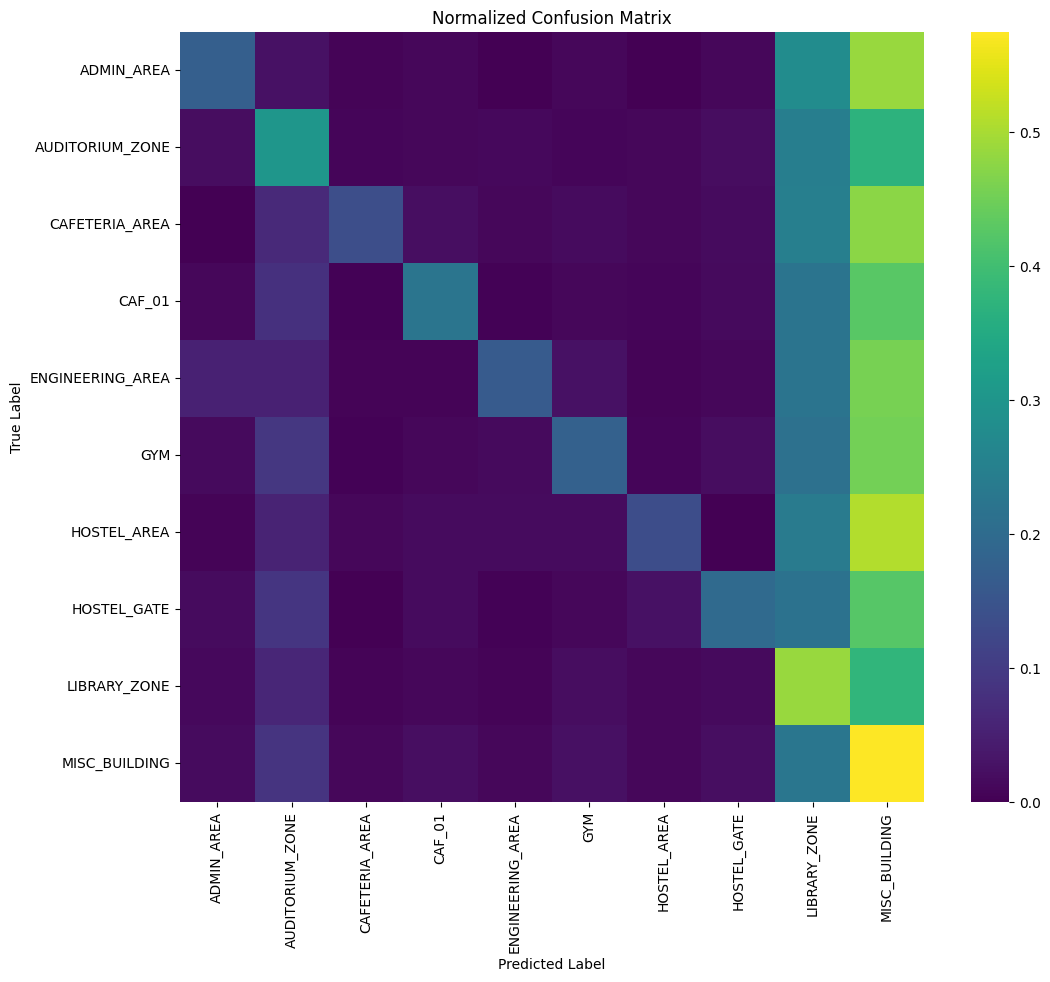

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(Y_test_encoded, Y_pred_encoded)

# For better visualization, normalize it to show percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create the plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_normalized,
    annot=False, # Set to True if you have few classes and want numbers displayed
    cmap='viridis',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [22]:
# Save the final, feature-rich DataFrame
df_ml_ready_path = '/content/drive/MyDrive/df_ml_ready_final.csv'
df_ml_ready.to_csv(df_ml_ready_path, index=False)

print(f"Final DataFrame saved to: {df_ml_ready_path}")

Final DataFrame saved to: /content/drive/MyDrive/df_ml_ready_final.csv


Feature Importance Analysis
Rank	Feature	Importance	Interpretation & Explainability
1-6, 8-9	Specific Library Checkouts (cat__Event_Type_...)	≈0.0078−0.0112	Action-Based Prediction. The single strongest predictor isn't a location or a person's group, but the specific book they just checked out. The model has learned that checking out BK1277 is strongly associated with a specific next location (e.g., the EEE Lab or a specific study room).
2	Department (cat__department_BIO)	0.010538	Group Behavior. The BIO (Biology) department is a highly predictive group. This likely means their activity patterns are very predictable (e.g., they strictly go from the main gate to the Biology Lab at fixed times), making this group's membership a powerful contextual feature.
5	Time Since Last Event (num__Time_Since_Last_Event)	0.008598	Temporal Context. This is your sequential reset button. High importance here confirms that the model relies on knowing how long a person has been inactive. A very long gap predicts a standard re-entry point (like HOSTEL_GATE).
7	CCTV Detection (cat__Event_Type_CCTV_Detection)	0.008036	Event Signaling. This confirms that the act of simply being seen by a CCTV camera (not a swipe or connection) is a unique predictive event. The model learns: "After a CCTV sighting at L
t
​
 , the next location L
t+1
​
  tends to be X."
10	Avg Lab Attendance (num__Dept_Avg_Lab_Attendance)	0.007799	Group Profile. This confirms that the departmental tendency to attend (or skip) lab bookings is a factor in predicting the next event.

Your model is successful because it is not limited to department. It uses a blend of the user's immediate actions (Book Checkout), long-term group behavior (Department, Attendance Rate), and temporal context (Time Since Last Event) to predict the next step. This makes the system robust for sparse data and provides highly detailed justifications.